In [14]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import recordreader
import pf360
import params
import time

In [54]:

m1 = pf360.camcal(320, 240, 10, -5)
ym1, ym2 = cv2.convertMaps(m1*2, None, cv2.CV_16SC2)
uvm1, uvm2 = cv2.convertMaps(m1, None, cv2.CV_16SC2)

m2 = pf360.camcal(640, 480, 300, -100, np.pi, -np.pi)
m2a, m2b = cv2.convertMaps(m2, None, cv2.CV_16SC2)


In [55]:
def yuvremap(yuv):
    # assumes 640x480 YUV420 image
    y = cv2.remap(yuv[:480], ym1, ym2, cv2.INTER_LINEAR)
    u = cv2.remap(yuv[480:480+120].reshape((240, 320)), uvm1, uvm2, cv2.INTER_LINEAR)
    v = cv2.remap(yuv[480+120:].reshape((240, 320)), uvm1, uvm2, cv2.INTER_LINEAR)
    return np.stack([y, u, v]).transpose(1, 2, 0)

32

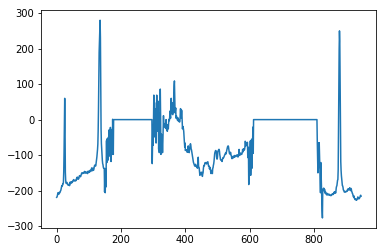

In [63]:
def frameloop():
    a = 0.02  # map scale
    L = pf360.L
    
    np.random.seed(1)
    Np = 300
    X = np.zeros((3, Np))
    X[0] = 0.125 * pf360.pseudorandn(Np)
    X[1] = 0.125 * pf360.pseudorandn(Np)
    X[2] = 0.1 * pf360.pseudorandn(Np)
    X.T[:, :3] += pf360.Lhome
    prevtstamp = None
    last_wheels = None
    vest2 = 0.0
    
    bg = cv2.imread("bball-2cm.png")
    f = open("/Users/asloane/git/cycloid/logs/cl20190119/cycloid-20190413-025211.rec", "rb")
    while True:
        ok, framedata = recordreader.read_frame(f)
        if not ok:
            break
            
        tstamp, carstate, particles, controldata, conesx, frame = framedata
        throttle, steering, accel, gyro, servo, wheels, periods = carstate
        frame = frame.reshape((-1, 640))
        if prevtstamp is None:
            prevtstamp = tstamp - 1.0 / 30
        if last_wheels is None:
            last_wheels = wheels
        dt = tstamp - prevtstamp
        if dt > 0.1:
            print('WARNING: frame', i, 'has a', dt, 'second gap')
        prevtstamp = tstamp
        tsfrac = tstamp - int(tstamp)
        tstring = time.strftime("%H:%M:%S.", time.localtime(tstamp)) + "%02d" % (tsfrac*100)
        gyroz = gyro[2]  # we only need the yaw rate from the gyro
        dw = wheels - last_wheels
        last_wheels = wheels
        #print('wheels', dw, 'periods', periods, 'gyro', gyroz, 'dt', dt)
        ds = np.sum(dw) * params.WHEEL_TICK_LENGTH / params.NUM_ENCODERS
        vest2 += 0.2*(ds / dt - vest2)
        pf360.step(X, dt, ds, gyroz, vest2, accel[1]*9.8)
        
        yuv = yuvremap(frame)
        bgr = cv2.cvtColor(frame, cv2.COLOR_YUV2BGR_I420)
        #bgr = cv2.cvtColor(yuv, cv2.COLOR_YUV2BGR)
        uv = yuv[:, :, 1:3].astype(np.int32) - 128
        #thr = ((uv[:, :, 0])/2 - (uv[:, :, 1])/2 + 128).astype(np.uint8)
        #thr = (uv[:, :, 1]/4 - uv[:, :, 0]/4 + 128).astype(np.uint8)
        #activation = (uv[:, :, 1]-40)*10 + 128
        activation = uv[:, :, 1]
        activation[yuv[:, :, 1] == 0] = 0
        thr = np.clip(activation + 128, 0, 255).astype(np.uint8)
        activation = np.sum(activation, axis=0)
        thr[:, np.argmax(activation)] = 255
        
        LL, coneangle = pf360.likelihood(X, activation)
        conex = coneangle.astype(np.int) % len(activation)
        thr[10:, conex.reshape(-1)] = 255
        if ds > 0:
            X = pf360.resample_particles(X, LL)
        

        #cv2.imshow("bgr", bgr)
        #cv2.imshow("bgr", cv2.remap(bgr, m2a, m2b, cv2.INTER_LINEAR))
        cv2.imshow("thr", thr)

        mapview = bg.copy()
        xi = np.uint32(X[0]/a)
        xj = np.uint32(-X[1]/a)
        xin = (xi >= 0) & (xi < mapview.shape[1]) & (xj >= 0) & (xj < mapview.shape[0])
        mapview[xj[xin], xi[xin], :] = 0
        mapview[xj[xin], xi[xin], 1] = 255
        mapview[xj[xin], xi[xin], 2] = 255
        
        x = np.mean(X, axis=1)
        P = np.cov(X)
        x0, y0 = x[:2] / a
        dx, dy = 20*np.cos(x[2]), 20*np.sin(x[2])
        U, V, _ = np.linalg.svd(P[:2, :2])
        axes = np.sqrt(V)
        angle = -np.arctan2(U[0, 1], U[0, 0]) * 180 / np.pi
        cv2.ellipse(mapview, (int(x0), -int(y0)), (int(axes[0]), int(axes[1])),
                    angle, 0, 360, (0, 0, 220), 1)
        cv2.circle(mapview, (int(x0), -int(y0)), 3, (0, 0, 220), 2)
        cv2.line(mapview, (int(x0), -int(y0)), (int(x0+dx), -int(y0+dy)), (0, 0, 220), 2)

        for l in range(len(L)):
            lxy = (int(L[l, 0]/a), -int(L[l, 1]/a))                                                                        
            cv2.circle(mapview, lxy, 3, (0, 128, 255), 3)                                                                           
            cv2.putText(mapview, "%d" % l, (lxy[0] + 3, lxy[1] + 3), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 1, cv2.LINE_AA)      
            
        cv2.putText(mapview, tstring, (20, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
        cv2.imshow("map", mapview)

        k = cv2.waitKey()
        if k == ord('q'):
            break
            ts
    return X, activation


X, activation = frameloop()
plt.plot(activation)
    
cv2.destroyAllWindows()
cv2.waitKey(1)